# Figure S4

## Decomposing drift-diffusion-based velocity

Here we examine the decomposed drift and diffusion of scDiffEq fit to the LARRY dataset.

### Import libraries

In [1]:
%load_ext nb_black

import numpy as np
import pandas as pd
import matplotlib.cm as cm
import scdiffeq as sdq
import pathlib
import cellplots as cp
import matplotlib.pyplot as plt
import larry
import scdiffeq_analyses as sdq_an

larry_cmap = larry.pl.InVitroColorMap()._dict

print(sdq.__version__, sdq.__path__)

0.1.1rc0 ['/home/mvinyard/github/scDiffEq/scdiffeq']


<IPython.core.display.Javascript object>

### Load data

In [2]:
h5ad_path = (
    "/home/mvinyard/data/adata.reprocessed_19OCT2023.more_feature_inclusive.h5ad"
)
adata = sdq.io.read_h5ad(h5ad_path)

AnnData object with n_obs × n_vars = 130887 × 2492
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated', 'train'
    var: 'gene_ids', 'hv_gene', 'must_include', 'exclude', 'use_genes'
    uns: 'fate_counts', 'h5ad_path', 'time_occupance'
    obsm: 'X_clone', 'X_pca', 'X_umap', 'cell_fate_df'
    layers: 'X_scaled'


<IPython.core.display.Javascript object>

### Load the model checkpoint

Here, we'll use a model checkpoint that was trained on the full LARRY dataset (further studied in Figure 4).

In [14]:
project_path = pathlib.Path(
    "/home/mvinyard/experiments/LARRY.full_dataset/LightningSDE-FixedPotential-RegularizedVelocityRatio"
)
project = sdq.io.Project(project_path)

<IPython.core.display.Javascript object>

In [145]:
results = sdq_an.parsers.summarize_best_checkpoints(project)
results

,train,test,ckpt_path,epoch
version_0,0.552548,0.508731,/home/mvinyard/experiments/LARRY.full_dataset/...,970
version_1,0.573248,0.54482,/home/mvinyard/experiments/LARRY.full_dataset/...,1499
version_2,0.579618,0.51688,/home/mvinyard/experiments/LARRY.full_dataset/...,2457
version_3,0.584395,0.542491,/home/mvinyard/experiments/LARRY.full_dataset/...,2500
version_4,0.574841,0.549476,/home/mvinyard/experiments/LARRY.full_dataset/...,2153


<IPython.core.display.Javascript object>

In [18]:
ckpt_path = results.loc["version_2"]["ckpt_path"]
model = sdq.io.load_model(adata=adata, ckpt_path=ckpt_path)

 - [INFO] | Input data configured.
 - [INFO] | Bulding Annoy kNN Graph on adata.obsm['train']


Seed set to 0


 - [INFO] | Using the specified parameters, LightningSDE-FixedPotential-RegularizedVelocityRatio has been called.


<IPython.core.display.Javascript object>

### Compute the snapshot drift and diffusion

We'll call the operations using the functions built into the model class. This will pass the data stored in the `model.adata` object through the functions. These can also be called independently on a different adata object through the `sdq.tl.` part of the API.

In [19]:
model.drift()
model.diffusion()

 - [INFO] | Added: adata.obsm['X_drift']
 - [INFO] | Added: adata.obsm['drift']
 - [INFO] | Added: adata.obsm['X_diffusion']
 - [INFO] | Added: adata.obsm['diffusion']


<IPython.core.display.Javascript object>

Smooth the drift and diffusion using kNN

In [20]:
smoother = sdq.tl.kNNSmoothing(model.adata)
model.adata.obs["smooth.diffusion"] = smoother("diffusion")

smoother = sdq.tl.kNNSmoothing(model.adata)
model.adata.obs["smooth.drift"] = smoother("drift")


(diffusion           0.357613
 smooth.diffusion    0.395817
 dtype: float32,
 diffusion           77.766747
 smooth.diffusion    44.928371
 dtype: float32)

<IPython.core.display.Javascript object>

In [146]:
df_inspect = model.adata.obs[["diffusion", "smooth.diffusion", "drift", "smooth.drift"]]
df_inspect.min(), df_inspect.max()

(diffusion           0.357613
 smooth.diffusion    0.395817
 drift               2.580779
 smooth.drift        5.338788
 dtype: float32,
 diffusion           77.766747
 smooth.diffusion    44.928371
 drift               77.875572
 smooth.drift        64.050613
 dtype: float32)

<IPython.core.display.Javascript object>

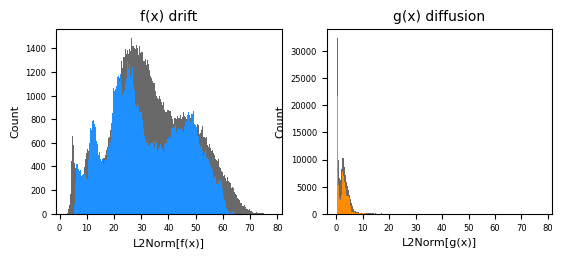

<IPython.core.display.Javascript object>

In [150]:
fig, axes = cp.plot(
    nplots=2,
    ncols=2,
    height=0.5,
    width=0.5,
    wspace=0.2,
    title=["f(x) drift", "g(x) diffusion"],
    x_label=["L2Norm[f(x)]", "L2Norm[g(x)]"],
    y_label=["Count", "Count"],
)
b2 = axes[0].hist(model.adata.obs["drift"], bins=210, color="dimgrey")
b1 = axes[0].hist(model.adata.obs["smooth.drift"], bins=210, color="dodgerblue")

b2 = axes[1].hist(model.adata.obs["diffusion"], bins=210, color="dimgrey")
b1 = axes[1].hist(model.adata.obs["smooth.diffusion"], bins=210, color="darkorange")

### Compute velocity graph and plot

We'll use the velocity components we've just computed to compute the velocity graph that will ultimately enable us to build a low-dimension vector field. 

**Note**: Since we've performed these operations on the `model.adata` object, we'll use that in this function, directly.

The following is the plot shown in Figure 2b of the manuscript.

### Velocity stream plots

First, plot with un-smoothed diffusion.

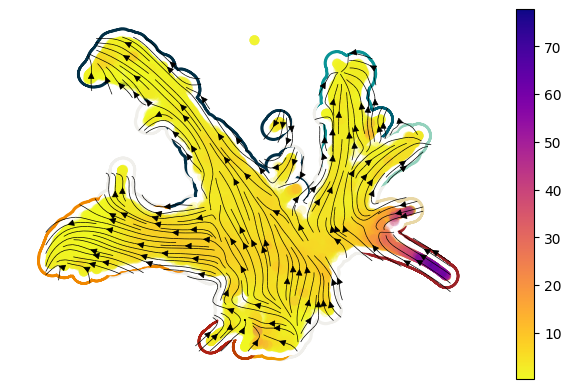

<IPython.core.display.Javascript object>

In [23]:
fig, axes = cp.plot(1, 1, height=1, width=1.2, del_xy_ticks=[True], delete="all")
ax = axes[0]
axes = cp.umap_manifold(
    adata,
    groupby="Cell type annotation",
    c_background=larry_cmap,
    ax=ax,
    s_background=350,
    s_cover=200,
)
sdq.pl.velocity_stream(
    model.adata,
    c="diffusion",
    cutoff_percentile=0.1,
    ax=ax,
    scatter_zorder=101,
    stream_zorder=201,
    scatter_kwargs={"rasterized": True},
)
plt.savefig("LARRY.example_velocity_stream.svg", dpi=500)

Next, plot with the smoothed diffusion:

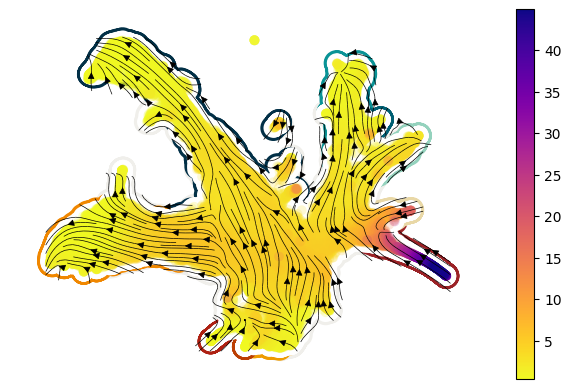

<IPython.core.display.Javascript object>

In [24]:
fig, axes = cp.plot(1, 1, height=1, width=1.2, del_xy_ticks=[True], delete="all")
ax = axes[0]
axes = cp.umap_manifold(
    adata,
    groupby="Cell type annotation",
    c_background=larry_cmap,
    ax=ax,
    s_background=350,
    s_cover=200,
)
sdq.pl.velocity_stream(
    model.adata,
    c="smooth.diffusion",
    cutoff_percentile=0.1,
    ax=ax,
    scatter_zorder=101,
    stream_zorder=201,
    scatter_kwargs={"rasterized": True},
)
plt.savefig("LARRY.example_velocity_stream.smooth.svg", dpi=500)

### Compute a composite velocity from decomposed drift and diffusion

In [99]:
fx = model.adata.obs["smooth.drift"]  #  * 0.1
gx = model.adata.obs["smooth.diffusion"]
vx = fx * 0.1 + gx

velo_df = pd.DataFrame({"fx": fx, "gx": gx, "vx": vx})
vmax = velo_df.max()

f_cmap = cp.tl.custom_cmap(max_color=cp.tl.convert_matplotlib_colorname("dodgerblue"))
g_cmap = cp.tl.custom_cmap(max_color=cp.tl.convert_matplotlib_colorname("darkorange"))
v_cmap = cp.tl.custom_cmap(max_color="#7678ed")

<IPython.core.display.Javascript object>

### UMAP plots: Supplementary Figure 4a

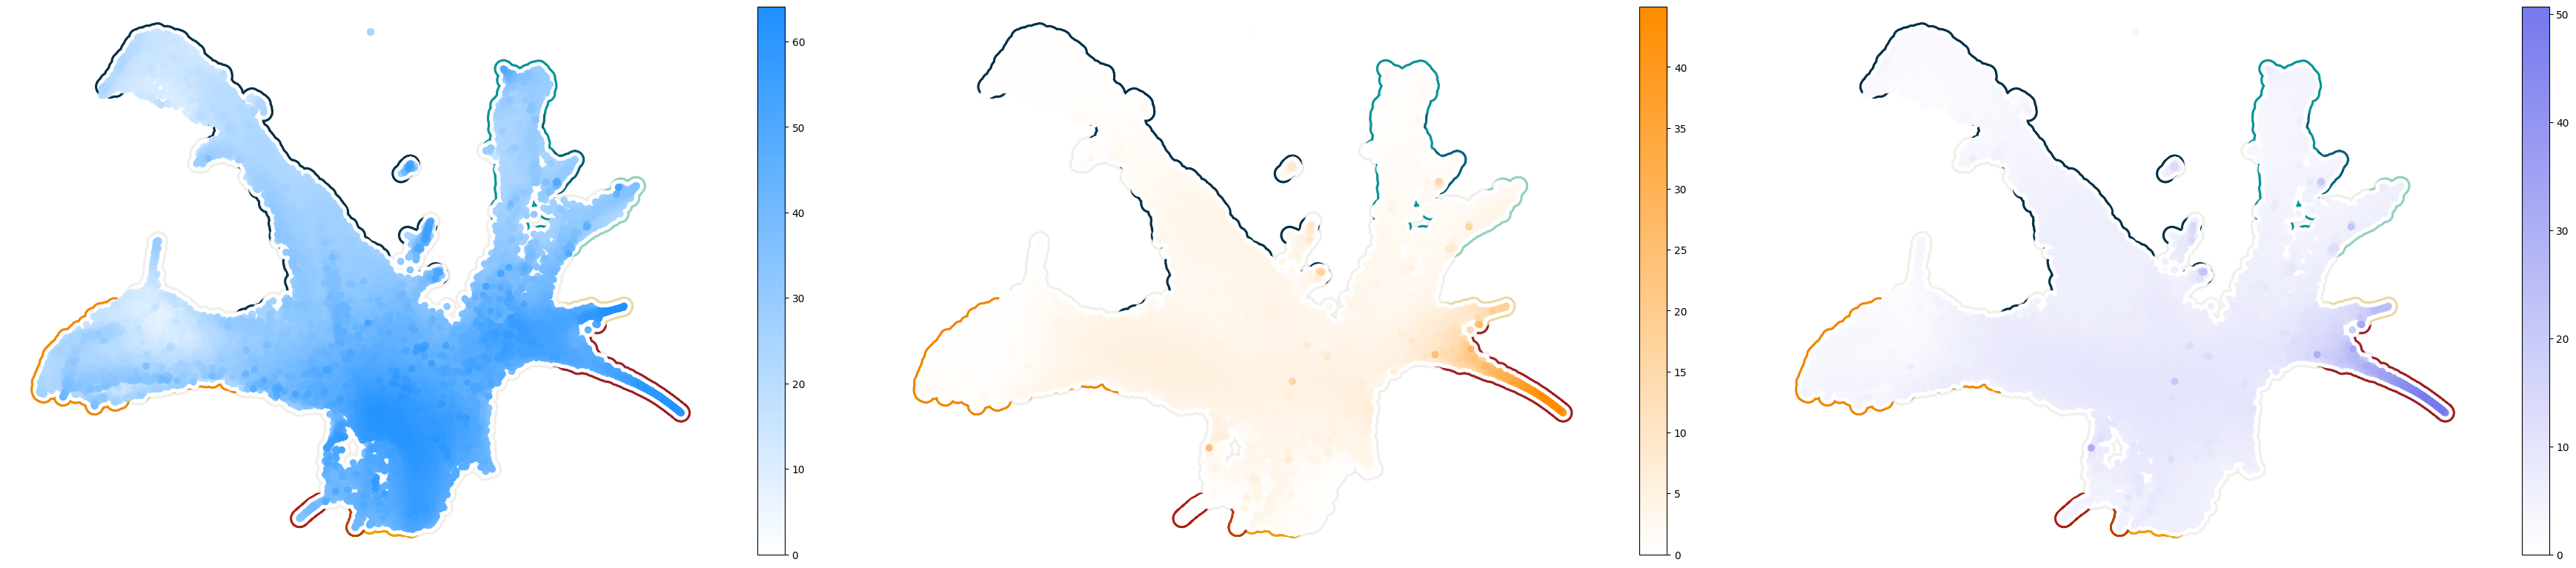

<IPython.core.display.Javascript object>

In [131]:
fig, axes = cp.plot(3, 3, height=2, width=2.4, del_xy_ticks=[True], delete="all")
xu = model.adata.obsm["X_umap"]
cmaps = [f_cmap, g_cmap, v_cmap]

for ax in axes:
    _ax = cp.umap_manifold(
        model.adata,
        groupby="Cell type annotation",
        c_background=larry_cmap,
        ax=ax,
        s_background=350,
        s_cover=200,
    )

for en, col in enumerate(velo_df):
    ax = axes[en]
    c = velo_df[col].values
    c_idx = np.argsort(c)
    img = ax.scatter(
        xu[c_idx, 0],
        xu[c_idx, 1],
        c=c[c_idx],
        zorder=300,
        vmin=0,
        rasterized=True,
        cmap=cmaps[en],
    )
    plt.colorbar(img)
plt.savefig("decomposed_velocity.svg", dpi=250)

### Histograms: Supplementary Figure 4b

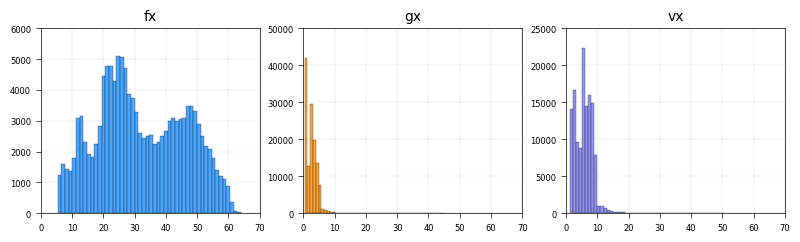

<IPython.core.display.Javascript object>

In [138]:
colors = ["dodgerblue", "darkorange", "#7678ed"]
fig, axes = cp.plot(
    3, 3, wspace=0.2, height=0.5, width=0.5, title=velo_df.columns.tolist()
)
xlims = [70, 50, 60]
ylims = [6000, 50_000, 25_000]
for en, col in enumerate(velo_df.columns):
    ax = axes[en]
    ax.hist(
        velo_df[col],
        bins=(50),
        color="w",
        alpha=1,
        ec="None",
        zorder=4,
    )
    ax.hist(
        velo_df[col], bins=(50), color=colors[en], alpha=0.8, ec="k", zorder=5, lw=0.25
    )
    ax.set_xlim(0, 70)  # , xlims[en])
    ax.set_ylim(0, ylims[en])
    ax.grid(True, c="lightgrey", lw=0.25, zorder=0)
    [spine.set_lw(0.5) for spine in ax.spines.values()]
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
plt.savefig("histogram.velo_decomposed.svg", dpi=500)